In [1]:
# Install libraries

!pip install --upgrade pip -q
!pip install "matplotlib>=3.9.0" -q
!pip install easyocr -q
!pip install torch -q
!pip install "transformers>=4.44.2" -q
!pip install gradio -q

import numpy as np
import torch
import matplotlib

print("NumPy:", np.__version__)
print("PyTorch:", torch.__version__)
print("Matplotlib:", matplotlib.__version__)
print("CUDA Available for PyTorch:", torch.cuda.is_available())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 10.1 MB/s eta 0:00:0000:010:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
ydata-profiling 4.17.0 requires matplotlib<=3.10,>=3.5, but you have matplotlib 3.10.7 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
mlxtend 0.23.4 requires scikit-learn>=1.3.1, but you have scikit-learn 1.2.2 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
libcugraph-cu12 25.6.0 requires libraft-cu12==25.6.*, but you have libraft-cu12 25.2.0 which is incompatible.
pylibcugraph-cu12 25.6.0 requires pylibraft-cu12==25.6.*

In [2]:
# Imports, Setup, Paths, Class List

import os
import sys
import random
import gc
from pathlib import Path

import numpy as np
import pandas as pd

import cv2
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Flatten,
    Dense, Dropout, BatchNormalization
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2

import torch
from torch.utils.data import Dataset
from torch.optim import AdamW

from transformers import (
    BertTokenizerFast,
    BertConfig,
    BertForMaskedLM,
    TrainingArguments,
    Trainer
)

import easyocr

# TensorFlow
tf.config.set_visible_devices([], 'GPU')
print("TensorFlow forced to CPU (safe).")

# PyTorch
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("PyTorch running on:", DEVICE)

# Paths
ROOT = Path("/kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset")

TRAIN_DIR = ROOT / "Training"
VAL_DIR   = ROOT / "Validation"
TEST_DIR  = ROOT / "Testing"

TRAIN_LABELS = TRAIN_DIR / "training_labels.csv"
VAL_LABELS   = VAL_DIR   / "validation_labels.csv"
TEST_LABELS  = TEST_DIR  / "testing_labels.csv"

TRAIN_IMG_DIR = TRAIN_DIR / "training_words"
VAL_IMG_DIR   = VAL_DIR   / "validation_words"
TEST_IMG_DIR  = TEST_DIR  / "testing_words"

WORKDIR = Path("/kaggle/working")
MODELS_DIR = WORKDIR / "models"
ARTIFACTS_DIR = WORKDIR / "artifacts"
MODELS_DIR.mkdir(parents=True, exist_ok=True)
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

# Image Settings
IMG_W, IMG_H = 128, 32
CHANNELS = 3
L2_REG = 1e-5
EPOCHS = 20
BATCH_SIZE = 32

# Load CSVs
train_df = pd.read_csv(TRAIN_LABELS)
val_df   = pd.read_csv(VAL_LABELS)
test_df  = pd.read_csv(TEST_LABELS)

print("Loaded CSV files:")
print("Train:", train_df.shape)
print("Val:  ", val_df.shape)
print("Test: ", test_df.shape)

# Create class list
class_names = sorted(train_df["MEDICINE_NAME"].unique().tolist())
num_classes = len(class_names)

cls2id = {c: i for i, c in enumerate(class_names)}
id2cls = {i: c for c, i in cls2id.items()}

print(f"Total classes: {num_classes}")
print(class_names)

# Save class list
with open(ARTIFACTS_DIR / "classes.txt", "w") as f:
    for c in class_names:
        f.write(c + "\n")


2025-11-27 11:36:22.440391: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764243382.809330      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764243382.902059      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

TensorFlow forced to CPU (safe).
PyTorch running on: cuda
Loaded CSV files:
Train: (3120, 3)
Val:   (780, 3)
Test:  (780, 3)
Total classes: 78
['Ace', 'Aceta', 'Alatrol', 'Amodis', 'Atrizin', 'Axodin', 'Az', 'Azithrocin', 'Azyth', 'Bacaid', 'Backtone', 'Baclofen', 'Baclon', 'Bacmax', 'Beklo', 'Bicozin', 'Canazole', 'Candinil', 'Cetisoft', 'Conaz', 'Dancel', 'Denixil', 'Diflu', 'Dinafex', 'Disopan', 'Esonix', 'Esoral', 'Etizin', 'Exium', 'Fenadin', 'Fexo', 'Fexofast', 'Filmet', 'Fixal', 'Flamyd', 'Flexibac', 'Flexilax', 'Flugal', 'Ketocon', 'Ketoral', 'Ketotab', 'Ketozol', 'Leptic', 'Lucan-R', 'Lumona', 'M-Kast', 'Maxima', 'Maxpro', 'Metro', 'Metsina', 'Monas', 'Montair', 'Montene', 'Montex', 'Napa', 'Napa Extend', 'Nexcap', 'Nexum', 'Nidazyl', 'Nizoder', 'Odmon', 'Omastin', 'Opton', 'Progut', 'Provair', 'Renova', 'Rhinil', 'Ritch', 'Rivotril', 'Romycin', 'Rozith', 'Sergel', 'Tamen', 'Telfast', 'Tridosil', 'Trilock', 'Vifas', 'Zithrin']


In [3]:
# Load Images + Preprocess + Build X/Y

from tqdm import tqdm

def load_and_preprocess_image(path: str):
    """
    Load image - resize - RGB - normalize.
    """
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Could not load image: {path}")

    img = cv2.resize(img, (IMG_W, IMG_H))          # (128, 32)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)     # Convert BGR → RGB
    img = img.astype(np.float32) / 255.0           # Normalize
    return img


def one_hot(labels, num_classes):
    """
    Fast one-hot encoder compatible with NumPy 2.x
    """
    arr = np.zeros((len(labels), num_classes), dtype=np.float32)
    arr[np.arange(len(labels)), labels] = 1.0
    return arr


def build_xy(df, img_dir: Path):
    """
    Build dataset:
      X: (N, 32, 128, 3)
      y: one-hot labels
    """
    N = len(df)
    X = np.zeros((N, IMG_H, IMG_W, CHANNELS), dtype=np.float32)
    y_idx = np.zeros(N, dtype=np.int32)

    print(f"\n Loading {N} images from: {img_dir}")

    for i, row in tqdm(df.iterrows(), total=N):
        img_path = str(img_dir / row["IMAGE"])
        X[i] = load_and_preprocess_image(img_path)
        y_idx[i] = cls2id[row["MEDICINE_NAME"]]

    y = one_hot(y_idx, num_classes)
    return X, y


# Build Train + Validation Sets

X_train, y_train = build_xy(train_df, TRAIN_IMG_DIR)
X_val,   y_val   = build_xy(val_df,   VAL_IMG_DIR)

print("\n Dataset Ready!")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_val:  ", X_val.shape)
print("y_val:  ", y_val.shape)



 Loading 3120 images from: /kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words


100%|██████████| 3120/3120 [00:24<00:00, 126.74it/s]



 Loading 780 images from: /kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words


100%|██████████| 780/780 [00:06<00:00, 121.44it/s]


 Dataset Ready!
X_train: (3120, 32, 128, 3)
y_train: (3120, 78)
X_val:   (780, 32, 128, 3)
y_val:   (780, 78)


In [4]:
# Build CNN model

def build_cnn_model(
    input_shape=(IMG_H, IMG_W, CHANNELS),
    num_classes=num_classes,
    l2_strength=L2_REG
):
    """
    CNN compatible with CPU-only TensorFlow (no cuDNN needed)
    """
    model = models.Sequential([
        Input(shape=input_shape),

        # Block 1
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        MaxPooling2D((2, 2)),

        # Block 2
        Conv2D(64, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_strength)),
        MaxPooling2D((2, 2)),

        # Block 3
        Conv2D(128, (3, 3), activation='relu', padding='same',
               kernel_regularizer=l2(l2_strength)),
        MaxPooling2D((2, 2)),

        # Dense layers
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(1024, activation='relu'),
        Dropout(0.5),

        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=1e-4),
        loss="categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

with tf.device('/CPU:0'):
    cnn_model = build_cnn_model()

cnn_model.summary()
print("\nCNN model successfully created on CPU.")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 128, 32)    │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 32, 64)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 32, 128)     │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 16, 128)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     4,194,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 78)             │        79,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,893,326 (18.67 MB)

 Trainable params: 4,893,326 (18.67 MB)

 Non-trainable params: 0 (0.00 B)


CNN model successfully created on CPU.


Starting CNN training on CPU...

Epoch 1/20


I0000 00:00:1764243447.232922     131 service.cc:148] XLA service 0x7977dc00eb00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764243447.234262     131 service.cc:156]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1764243448.843677     131 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0156 - loss: 4.3732
Epoch 1: val_loss improved from inf to 4.35665, saving model to /kaggle/working/models/cnn_model_cpu_safe.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 124s 1s/step - accuracy: 0.0156 - loss: 4.3731 - val_accuracy: 0.0115 - val_loss: 4.3567
Epoch 2/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0190 - loss: 4.3572
Epoch 2: val_loss improved from 4.35665 to 4.35364, saving model to /kaggle/working/models/cnn_model_cpu_safe.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.0190 - loss: 4.3572 - val_accuracy: 0.0179 - val_loss: 4.3536
Epoch 3/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0101 - loss: 4.3551
Epoch 3: val_loss improved from 4.35364 to 4.33306, saving model to /kaggle/working/models/cnn_model_cpu_safe.keras
98/98 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.0101 - loss: 4.3551 - val_accuracy: 0.0128 - val_loss: 4.3331
Epoch 4/20
98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.0231 - 

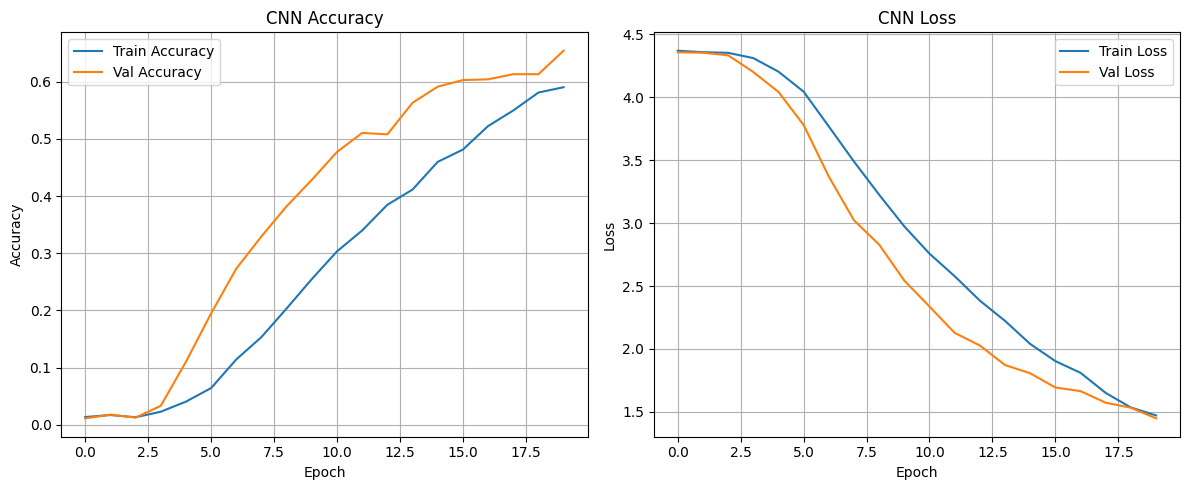

In [5]:
# Train CNN

CNN_SAVE_PATH = MODELS_DIR / "cnn_model_cpu_safe.keras"

print("Starting CNN training on CPU...\n")

with tf.device('/CPU:0'):

    history = cnn_model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[
            EarlyStopping(
                monitor="val_loss",
                patience=3,
                restore_best_weights=True
            ),
            ModelCheckpoint(
                filepath=str(CNN_SAVE_PATH),
                save_best_only=True,
                monitor="val_loss",
                verbose=1
            )
        ],
        verbose=1
    )

print("\nTraining completed successfully!")
print("Best CNN model saved at:", CNN_SAVE_PATH)


# Plot Training Curves

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.title("CNN Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True)
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("CNN Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()


In [6]:
# OCR Extraction using EasyOCR

print("Initializing EasyOCR...")
ocr_reader = easyocr.Reader(['en'], gpu=False)   

def ocr_extract_text(image_path: str):
    """
    Extract text from an image using EasyOCR.
    Returns the string result.
    """
    try:
        result = ocr_reader.readtext(image_path, detail=0)
        if len(result) == 0:
            return ""
        return " ".join(result)
    except:
        return ""


def build_ocr_dataset(df, img_dir: Path):
    """
    For BERT later:
    Returns two lists:
      X_text: OCR output text
      y_text: corresponding medicine names
    """
    X_text = []
    Y_text = []

    print(f"\n Running OCR on {len(df)} images from {img_dir} ...")

    for _, row in tqdm(df.iterrows(), total=len(df)):
        img_path = str(img_dir / row["IMAGE"])
        text = ocr_extract_text(img_path)

        X_text.append(text)
        Y_text.append(row["MEDICINE_NAME"])

    return X_text, Y_text


# Build OCR datasets for Training / Validation

X_ocr_train, y_ocr_train = build_ocr_dataset(train_df, TRAIN_IMG_DIR)
X_ocr_val,   y_ocr_val   = build_ocr_dataset(val_df,   VAL_IMG_DIR)

print("\nOCR extraction complete!")
print("Example OCR text:", X_ocr_train[0])
print("Example Label:    ", y_ocr_train[0])


Initializing EasyOCR...

 Running OCR on 3120 images from /kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Training/training_words ...


100%|██████████| 3120/3120 [05:36<00:00,  9.26it/s]



 Running OCR on 780 images from /kaggle/input/doctors-handwritten-prescription-bd-dataset/Doctor’s Handwritten Prescription BD dataset/Validation/validation_words ...


100%|██████████| 780/780 [01:23<00:00,  9.33it/s]


OCR extraction complete!
Example OCR text: Aeea
Example Label:     Aceta


In [7]:
# Build BERT Vocabulary + Tokenizer + Dataset

import string

# Allowed characters from OCR output
basic_chars = list(
    string.ascii_lowercase +
    string.ascii_uppercase +
    string.digits +
    " -_.,:/()[]"
)

# Special tokens
special_tokens = ["[PAD]", "[UNK]", "[CLS]", "[SEP]", "[MASK]"]

# Build final vocab list
vocab_list = special_tokens + basic_chars

# Save vocab file
vocab_path = ARTIFACTS_DIR / "vocab.txt"
with open(vocab_path, "w") as f:
    for token in vocab_list:
        f.write(token + "\n")

print("BERT vocab size:", len(vocab_list))
print("Vocab saved to:", vocab_path)

# Initialize Tokenizer
tokenizer = BertTokenizerFast(vocab_file=str(vocab_path))
tokenizer.pad_token = "[PAD]"
tokenizer.cls_token = "[CLS]"
tokenizer.sep_token = "[SEP]"
tokenizer.mask_token = "[MASK]"
tokenizer.unk_token = "[UNK]"

print("Tokenizer created successfully")

# PyTorch Dataset for BERT
class OcrBertDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y, tokenizer, max_len=128):
        self.X = X
        self.Y = Y
        self.tok = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x_text = self.X[idx]
        y_text = self.Y[idx]

        # Tokenize inputs
        inputs = self.tok(
            x_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        # Tokenize labels (teacher forcing)
        labels = self.tok(
            y_text,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": labels["input_ids"].squeeze()
        }

print("BERT dataset class ready.")

# Build PyTorch datasets
train_dataset = OcrBertDataset(X_ocr_train, y_ocr_train, tokenizer)
val_dataset   = OcrBertDataset(X_ocr_val,   y_ocr_val,   tokenizer)

print("BERT datasets created")
print("Train size:", len(train_dataset))
print("Val size:  ", len(val_dataset))


BERT vocab size: 78
Vocab saved to: /kaggle/working/artifacts/vocab.txt
Tokenizer created successfully
BERT dataset class ready.
BERT datasets created
Train size: 3120
Val size:   780


In [8]:
# BERT Model + Training

print("Initializing BERT model on", DEVICE)

# BERT Configuration
bert_config = BertConfig(
    vocab_size=len(vocab_list),
    hidden_size=256,
    num_hidden_layers=6,
    num_attention_heads=8,
    intermediate_size=512,
    max_position_embeddings=256
)

bert_model = BertForMaskedLM(bert_config)
bert_model.to(DEVICE)

print("BERT model created!")

# Training Arguments
training_args = TrainingArguments(
    output_dir=str(ARTIFACTS_DIR / "bert_output"),
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    learning_rate=1e-4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_steps=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=1,
    report_to="none",
)

# Accuracy Metric
def compute_accuracy(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = (preds == labels).mean()
    return {"accuracy": acc}

# Trainer
trainer = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_accuracy,
)

print("Starting BERT training...\n")
trainer.train()

print("\nBERT Training Completed!")


# Save final model
bert_save_path = ARTIFACTS_DIR / "bert_final"
trainer.save_model(str(bert_save_path))
print(f"BERT model saved to: {bert_save_path}")


Initializing BERT model on cuda
BERT model created!
Starting BERT training...



/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.010200,0.009752,0.999099
2,0.006000,0.006164,0.999159
3,0.004600,0.005631,0.999209


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(



BERT Training Completed!
BERT model saved to: /kaggle/working/artifacts/bert_final


In [9]:
# Combined Predictor (CNN + OCR + BERT)

print("Loading trained CNN model...")
with tf.device('/CPU:0'):
    loaded_cnn = tf.keras.models.load_model(CNN_SAVE_PATH)

print("CNN loaded from:", CNN_SAVE_PATH)


print("\nLoading trained BERT model...")
bert_model = BertForMaskedLM.from_pretrained(str(ARTIFACTS_DIR / "bert_final"))
bert_model.to(DEVICE)
bert_model.eval()

print("BERT loaded successfully.")


# CNN Prediction
def cnn_predict(image_path: str):
    """
    Runs the trained CNN on an image and returns the predicted class name.
    """
    img = load_and_preprocess_image(image_path)
    img = np.expand_dims(img, axis=0)               # (1, 32, 128, 3)

    with tf.device('/CPU:0'):
        preds = loaded_cnn.predict(img, verbose=0)

    class_id = np.argmax(preds)
    return id2cls[class_id]


# OCR + BERT Refinement
def bert_refine_text(text: str):
    """
    Runs OCR output through BERT to get the final corrected medicine name.
    """
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    ).to(DEVICE)

    with torch.no_grad():
        outputs = bert_model(**inputs)

    logits = outputs.logits
    preds = torch.argmax(logits, dim=-1)[0].cpu().numpy()

    decoded = tokenizer.decode(preds, skip_special_tokens=True)
    return decoded.strip()


# Full Prediction
def predict_medicine(image_path: str):
    """
    End-to-end pipeline:
      CNN - OCR - BERT - Final name
    """
    print("\nStarting prediction...")

    # CNN Prediction
    cnn_name = cnn_predict(image_path)
    print("CNN predicts:", cnn_name)

    # OCR Extract Text
    ocr_text = ocr_extract_text(image_path)
    print("OCR extracted text:", ocr_text)

    # BERT refinement
    refined_name = bert_refine_text(ocr_text)
    print("BERT refined:", refined_name)

    # Final combined decision logic:
    # If BERT output empty - trust CNN
    if refined_name.strip() == "":
        final_name = cnn_name
    else:
        final_name = refined_name

    return {
        "cnn": cnn_name,
        "ocr": ocr_text,
        "bert": refined_name,
        "final_prediction": final_name,
    }


print("\nCombined prediction system is ready!")


Loading trained CNN model...
CNN loaded from: /kaggle/working/models/cnn_model_cpu_safe.keras

Loading trained BERT model...
BERT loaded successfully.

Combined prediction system is ready!


In [10]:
# Gradio UI for Medicine Prediction

import gradio as gr

def gradio_predict(image):
    """
    Gradio interface wrapper for prediction pipeline.
    """
    if image is None:
        return "No image uploaded.", "", "", ""

    # Save uploaded image temporarily
    temp_path = "/kaggle/working/temp_input.png"
    image.save(temp_path)

    # Run full prediction
    result = predict_medicine(temp_path)

    return (
        result["final_prediction"],   # Final result
        result["cnn"],                # CNN prediction
        result["ocr"],                # OCR text
        result["bert"]                # BERT refinement
    )


# Build Gradio UI
interface = gr.Interface(
    fn=gradio_predict,
    inputs=gr.Image(type="pil", label="Upload Prescription Word Image"),
    outputs=[
        gr.Textbox(label="Final Prediction (Medicine Name)"),
        gr.Textbox(label="CNN Prediction + BERT Refined Output"),
        gr.Textbox(label="OCR Extracted Text"),
    ],
    title="Medicine Name Predictor (CNN + OCR + BERT)",
    description="Upload a handwritten prescription word image to predict the medicine name.",
    allow_flagging="never"
)

# Launch UI
interface.launch(debug=False)


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:425: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated. Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

* Running on public URL: https://b8f06e0db7d3fb8af1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
